ver: 20201208.1342

In [1]:
# Initialization for this notebook.

import numpy as np
from scipy import signal
from scipy import fft
import matplotlib.pyplot as plt

# Common sequence generators.
seq_delta = lambda n_min, n_max: (np.array([ 1 if n==0 else 0 for n in range(n_min, n_max+1)]), 0 - n_min)
seq_u = lambda n_min, n_max: (np.array([ 0 if n<0 else 1 for n in range(n_min, n_max+1)]), 0-n_min)
seq_R_N = lambda N, n_min, n_max: (np.array([ 0 if (n<0 or n>=N) else 1 for n in range(n_min, n_max+1)]), 0-n_min)
seq_real_exp = lambda a, n_min, n_max: (np.array([ 0 if n<0 else a**n for n in range(n_min, n_max+1)]), 0-n_min)
seq_complex_exp = lambda sigma, omega_0, n_min, n_max: (np.array([ np.exp((sigma + 1j*omega_0)*n) for n in range(n_min, n_max+1)]), 0-n_min)
seq_sin = lambda A, omega_0, phi, n_min, n_max: (np.array([ A*np.sin(omega_0*n + phi) for n in range(n_min, n_max+1)]), 0-n_min)

# Un-comment the following line to use interactive matplotlib widget.
#%matplotlib widget

In [2]:
# A selection of tick format functions that can be used by `analyze_filter`.
def tick_format_rad_to_pi(value, tick_number):
    """Convert value (in rad) to multiple of pi."""
    return ('%.2f' % (value/np.pi)).rstrip('0').rstrip('.') + '$\pi$'

def tick_format_append_pi(value, tick_number):
    """Append pi symbol to the value."""
    return ('%.2f' % (value)).rstrip('0').rstrip('.') + '$\pi$'

def tick_format_append_hz(value, tick_number):
    """Append Hz unit to the value."""
    return ('%.2f' % (value)).rstrip('0').rstrip('.') + 'Hz'

def analyze_filter(bands, b, a=1, show_plot=False, samples_per_band=129, fs=2, tick_format=tick_format_append_pi, amp_in_dB=True):
    """Find the R_p and A_s of the given filter and optionally show the frequency response plots.
    
    Parameters:
      bands : array_like
        A list of tuples, `(band_type, band_start, band_end)`, to describe each band.
        `band_type`: str, one of 'pass', 'tran', 'stop'
        `band_start`, `band_end`: float, the start and end frequencies, normalized to `fs`.
      b : array_like
        Numerator of the transfer function.
      a : array_like, optional
        Denominator of the transfer function. Default is 1 (FIR filter).
      show_plot : bool, optional
        Set to True to show the frequency response plots. Default is False.
      samples_per_band : int, optional
        Number of frequency samples per band (pass, transition and stop). Generally, more samples will give more accurate results. Default is 129.
      fs: float, optional
        Sampling frequency. Default is 2. (Tips: set to 2*numpy.pi for representing frequencies in rad/sample.)
      tick_format: function, optional
        Function to format tick values on x-axis. Default is `tick_format_append_pi`, which append a pi symbol to the values.
      amp_in_dB: bool, optional
        Whether the amplitude is represented in dB or not. Default is True.
    
    Returns:
      R_p: float
        Pass band ripple, in dB if amp_in_dB is True.
      A_s: float
        Stop band attenuation, in dB if amp_in_dB is True.
    """

    if amp_in_dB:
      dB = lambda x: 20 * np.log10(x)
      amp_unit = '(dB)'
    else:
      dB = lambda x: x
      amp_unit = ''

    NUM_BANDS = len(bands)
    [BAND_TYPE, BAND_START, BAND_END] = range(3)

    # Compute frequency respone samples for each band.
    w = []      # To store frequency samples for each band.
    H = []      # To store frequency respone samples for each band.
    for (band_type, w_start, w_end) in bands:
        w_tmp, H_tmp = signal.freqz(
          b=b, a=a, 
          worN=np.linspace(w_start, w_end, samples_per_band), 
          fs=fs)
        w.append(w_tmp)
        H.append(H_tmp)

    # Normalize |H| to 1.     
    H_abs = np.abs(H)
    H_norm_factor = np.max(H_abs)
    H = H / H_norm_factor
    H_abs = H_abs / H_norm_factor

    # Find the minimum pass band ripple and maximum stop band attenuation (across all respective bands).
    pass_min = 1
    stop_max = 0
    for band in range(NUM_BANDS):
      band_type = bands[band][BAND_TYPE]
      if band_type=='pass':
        pass_min = min(pass_min, np.min(H_abs[band]))
      elif band_type=='stop':
        stop_max = max(stop_max, np.max(H_abs[band]))
    pass_min, stop_max = dB(pass_min), dB(stop_max)
    
    if show_plot:
        NUM_PLOTS = 2
        [AMP_PLOT, PHASE_PLOT] = range(NUM_PLOTS)
        BAND_COLOR = {'pass':'green', 'tran':'blue', 'stop':'red'}

        fig, axs = plt.subplots(NUM_PLOTS, 1 ,sharex='col')

        # Plot the frequency response.
        for band in range(NUM_BANDS):
            band_type = bands[band][BAND_TYPE]
            axs[AMP_PLOT].plot(w[band], dB(H_abs[band]), color=BAND_COLOR[band_type])
            axs[PHASE_PLOT].plot(w[band], np.angle(H[band]), color=BAND_COLOR[band_type])
        axs[AMP_PLOT].legend([bands[band][0] for band in range(3)])
        axs[PHASE_PLOT].set_xlim(left=0, right=fs/2)
        axs[AMP_PLOT].set_ylabel('Amplitude' + amp_unit)
        axs[PHASE_PLOT].set_ylabel('Phase')
        axs[PHASE_PLOT].set_xlabel('Frequency')
        axs[AMP_PLOT].grid()
        axs[PHASE_PLOT].grid()

        # Set the tick format
        axs[PHASE_PLOT].xaxis.set_major_formatter(plt.FuncFormatter(tick_format))
        axs[PHASE_PLOT].xaxis.set_major_locator(plt.MultipleLocator(fs/8))
        axs[PHASE_PLOT].yaxis.set_major_formatter(plt.FuncFormatter(tick_format_rad_to_pi))
        axs[PHASE_PLOT].yaxis.set_major_locator(plt.MultipleLocator(np.pi/2))

        # Add horizontal lines to indicate R_p and A_s.
        axs[AMP_PLOT].axhline(y=pass_min, linestyle='--', color=BAND_COLOR['pass'])
        axs[AMP_PLOT].axhline(y=stop_max, linestyle='--', color=BAND_COLOR['stop'])
        axs[AMP_PLOT].secondary_yaxis('right').set_yticks([pass_min, stop_max])

        # Add vertical lines to indicate band egdes.
        band_edges = []
        for band in range(NUM_BANDS):
          band_type, band_start, band_end = bands[band]
          if band_type=='tran':
            for plot in range(NUM_PLOTS):
              axs[plot].axvline(band_start, linestyle='--')
              axs[plot].axvline(band_end, linestyle='--')
              band_edges.append(band_start)
              band_edges.append(band_end)
        ax_phase_top = axs[PHASE_PLOT].secondary_xaxis('top')
        ax_phase_top.xaxis.set_major_formatter(plt.FuncFormatter(tick_format))
        ax_phase_top.set_xticks(band_edges)

    if amp_in_dB:
      R_p, A_s = -pass_min, -stop_max
    else:
      R_p, A_s = pass_min, stop_max
    return R_p, A_s

In [3]:
def test_filter(b, a, x):
    """Test a filter by comparing the input and output.

    Parameters:
      b : array_like
        Numerator of the transfer function.
      a : array_like
        Denominator of the transfer function.
      x : array_like
        Input sequence.
    
    Returns:
      y : array_like
        Output sequence.
    """
    y = signal.lfilter(b=b, a=a, x=x)

    X = fft.fft(x)
    Y = fft.fft(y)

    def tick_format_pi(value, tick_number):
        return ('%.2f' % (value/np.pi)).rstrip('0').rstrip('.') + '$\pi$'

    NUM_PLOTS = 2
    [TIME_PLOT, FREQ_PLOT] = range(NUM_PLOTS)
    fig, axs = plt.subplots(NUM_PLOTS,1)

    N = len(x)
    n = np.arange(N)
    axs[TIME_PLOT].plot(n, x, linewidth=3, color='red', alpha=0.5)
    axs[TIME_PLOT].plot(n, y, linewidth=2, color='green');
    axs[TIME_PLOT].legend(['x', 'y'])
    axs[TIME_PLOT].set_xlabel('n')

    w = n*2*np.pi/N
    axs[FREQ_PLOT].plot(w, abs(X), color='red', alpha=0.5)
    axs[FREQ_PLOT].plot(w, abs(Y), color='green')
    axs[FREQ_PLOT].legend(['|X|', '|Y|'])
    axs[FREQ_PLOT].set_xlabel('$\omega$')
    axs[FREQ_PLOT].xaxis.set_major_formatter(plt.FuncFormatter(tick_format_pi))
    axs[FREQ_PLOT].xaxis.set_major_locator(plt.MultipleLocator(np.pi/4))

    return y

【例7.4】 要设计一个线性相位FIR带通滤波器，其下阻带截止频率为$f_{st1}$=2kHz,上阻带截止频率为$f_{st2}$=6kHz，通带下截止为$f_{p1}$=3kHz，通带上截止频率为$f_{p2}$=5kHz,阻带最小衰减为55dB，抽样频率为$f_s$=20kHz。采用窗函数法设计。

解：

根据要求的阻带衰减，查课本表7.3可得布莱克曼窗(`blackman`)是符合要求的窗函数中，过渡带最窄的($11\pi/N$)。

N = 110, R_p = 0.005156, A_s = 67.830189


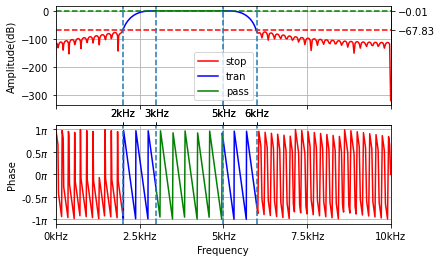

In [4]:
# All frequencies are in Hz.
fs = 20e3
f_st_1, f_p_1 = 2e3, 3e3
f_p_2, f_st_2 = 5e3, 6e3
A_s_traget = 55     # in dB

# Find the minimum transition band width.
f_tran_min = min(abs(f_p_1-f_st_1), abs(f_p_2-f_st_2))

# Compute window property.
window = 'blackman'
window_tran = 11 * (fs/2)
N = int(np.ceil(window_tran/f_tran_min))

f_c_1 = (f_p_1 + f_st_1)/2
f_c_2 = (f_p_2 + f_st_2)/2
b = signal.firwin2(
    N, 
    [0, f_c_1, f_c_1, f_c_2, f_c_2, fs/2],  # frequency points
    [0, 0,     1,     1,     0,     0],     # gain at each point
    window=window, fs=fs)
a = 1

# Analyze the filter.
bands= [
    ('stop', 0, f_st_1), 
    ('tran', f_st_1, f_p_1), 
    ('pass', f_p_1, f_p_2), 
    ('tran', f_p_2, f_st_2), 
    ('stop', f_st_2, fs/2)
    ]
def tick_format_to_khz(value, tick_number):
    """Show the value in kHz"""
    return ('%.2f' % (value/1000)).rstrip('0').rstrip('.') + 'kHz'
R_p, A_s = analyze_filter(bands, b=b, a=a, show_plot=True, fs=fs, tick_format=tick_format_to_khz, amp_in_dB=True)
print('N = %d, R_p = %f, A_s = %f' % (N, R_p, A_s))

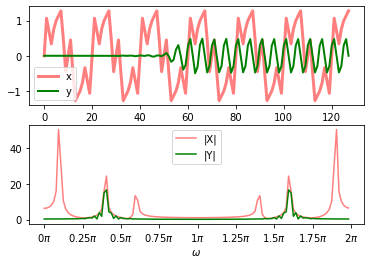

In [5]:
def gen_signal():
    # Create a list of parameters, (A, w, phi), for each sin component.
    x_comp = []
    x_comp.append((1,   2*np.pi * 1e3/fs, 0))    # in the stop band
    x_comp.append((0.5, 2*np.pi * 4e3/fs, 0))    # in the pass band
    x_comp.append((0.3, 2*np.pi * 6e3/fs, 0))    # in the stop band
    
    # Generate the sequence by combining all sin components.
    n_min, n_max = 0, 127
    x = np.sum([seq_sin(A, w, phi, n_min, n_max) for A, w, phi in x_comp], axis=0)[0]

    return x

x = gen_signal()
test_filter(b, a, x);

# 【作业】

- 用凯泽窗口(Kaiser)设计一个与上述滤波器技术指标相同但功能是互补的带阻FIR滤波器。
  - 不查表，使用 scipy.signal 中的函数来完成
- 使用`analyze_filter()`来分析所设计的滤波器的频率响应
- 使用`test_filter()`来验证所设计滤波器的实际效果